# County-level Covid-19 Analysis for US States

This notebook utilizes data kindly made available by the JHU Systems Group at 
https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

and used for their 
[Visual Dashboad](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).  It provides a temporal perspective that complements their excellent geospatial presentation.  

The thing about exponentials with a measurable daily growth rate is they change so fast.  With cases increasing 25% per day,a week means a factor of 5 and a month a factor of a thousand.


* Repo for this and other notebnooks at: [https://github.com/deculler/covid19](https://github.com/deculler/covid19)
* Website for this repo: [https://deculler.github.io/covid19/](https://deculler.github.io/covid19/)

## View and run the notebooks

* [View the notebook with nbviewer](https://nbviewer.jupyter.org/github/deculler/covid19/blob/master/US-covid19-JHU.ipynb)
* [Launch it on mybinder.org](https://mybinder.org/v2/gh/deculler/covid19/master?filepath=work/US-covid19-JHU.ipynb)
* [@UCB on datahub.berkeley.edu](http://datahub.berkeley.edu/user-redirect/interact?account=deculler&repo=covid19&branch=master&path=US-covid19-JHU.ipynb)
  
## Quick links to sections

* [Cases by state](#sectionCases)
* [Deaths by state](#sectionDeaths)
* [Growth trends by state](#sectionGrowth)
* [Cases one state](#sectionOneState)
* [Projection of cases in one state](#sectionProj)
* [Projection of deaths in one state](#sectionProjDeath)

The dataset only contains confirmed cases and death, not recoveries.  The data on recoveries tends not to be very good anyways, because case tracking is so poor.  But more importantly, the level of penetration of the virus is still in such an early stage that the eventual balancing out in the SIR models is irrelevant.  With infections growing at 15% per day, if all of today's cases recovered two weeks out, it would only be 1/16th of the new cases.  We are looking at days and weeks, not months and years.

For dataframes it uses Datascience Tables (for reference see http://data8.org/datascience/tables.html) developed for introductory courses as UCB.

In [1]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
import scipy
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [2]:
import sys
if not '.' in sys.path:
    sys.path.append(".")

# Timeseries derivative of the Tables Datafram module
from timetable import TimeTable

# Tools used throughout the notebook
from covid import *

def label_val(trend, x, val):
    x_val = trend.get(x, trend.time_column)
    y_val = trend.get(x, val)
    plots.text(x_val, y_val, "{:,}".format(int(y_val)))

def add_lines(trend, col, ymax, ymin, lines):
    skip = (ymax - ymin) / len(lines) 
    y = ymax
    my = np.nanmin(trend[col])
    for (date, text) in lines :
        plots.text(date, y, text)
        plots.plot([date, date], [my, y], ":")
        y = y - skip
        
def proj_trend(trend, col, start=7, end=0, dist=14):
    last_day = trend.last(trend.time_column)
    fit_start = inc_day(last_day, -start)
    end = min(end, start)
    fit_end = inc_day(last_day, -end)
    proj_prog(trend, col, dist, fit_start=fit_start, fit_end=fit_end)

## Pull Data

URL for https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

In [3]:
stateCasesURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv" 
stateDeathsURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv" 

In [4]:
raw_states_cases = Table.read_table(stateCasesURL)
raw_states_deaths = Table.read_table(stateDeathsURL)

In [5]:
# Number of Counties
states = list(np.unique(raw_states_cases['Province_State']))
US_counties = list(np.unique(raw_states_cases['Admin2']))
len(states), len(US_counties)

(58, 1979)

<a id='selectState'></a>
## Select state to examine at county level

Choose a state and run all cells below.

In [6]:
w = widgets.Dropdown(
    options = states,
    value ='California',
    # rows=10,
    description='State:',
    disabled=False
)
w

Dropdown(description='State:', index=5, options=('Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',…

In [7]:
state = w.value
raw_state_cases = raw_states_cases.where('Province_State', state)
raw_state_deaths = raw_states_deaths.where('Province_State', state)

In [8]:
raw_state_cases

UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20
84006001,US,USA,840,6001,Alameda,California,US,37.6463,-121.893,"Alameda, California, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,3,5,5,7,11,11,18,27,30,38,48,68,71,118,135,135,178,220,220,270,283,313,313,359,443,443,566,588,634,674,674,766,806,845,888,888,964,1007,1063,1114,1164,1193,1241,1242,1352,1403,1439,1470,1500,1533,1568,1603,1636,1706,1749,1776,1809,1863,1917,1961,2023,2064,2101,2133,2178,2234,2367,2351,2392,2457,2522,2560,2609,2708,2760,2847,2874,2986,3049,3097,3195,3289,3390,3470,3515,3548,3641,3725,3805,3805,3945,3985,4033,4232,4216,4217,4320,4373,4481,4533,4638,4702,4924,4924,5007,5267,5275,5382,5493,5493,5670,5762,5964,6156,6384,6472,6556,6855,6855,6925,7245,7407,7485,7725,7731,7976,8321,8478,8627,8858,9110
84006003,US,USA,840,6003,Alpine,California,US,38.5968,-119.822,"Alpine, California, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
84006005,US,USA,840,6005,Amador,California,US,38.4458,-120.657,"Amador, California, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,2,2,2,2,2,2,2,3,3,3,0,3,3,3,3,7,7,7,7,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,9,9,9,9,9,10,10,10,10,10,10,10,10,10,10,10,10,10,19,10,10,10,10,10,10,10,10,10,10,10,10,10,10,11,12,12,12,12,13,13,22,16,19,20,20,20,21,22,22,24,26,26,31,31,33,34,35,36,36,40,40,40,45,48,49,51,51
84006007,US,USA,840,6007,Butte,California,US,39.6673,-121.601,"Butte, California, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,4,5,5,5,5,5,8,8,9,10,11,11,11,12,13,13,13,14,14,14,15,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,17,17,18,18,18,18,18,20,20,20,22,22,22,22,24,26,30,31,34,34,34,34,40,40,40,44,44,44,51,51,55,60,65,65,65,68,71,73,73,74,74,74,82,88,90,90,94,94,94,111,119,127,133,143,143,143,168,168,189,206,206,206,206,206,275,295,319,338,338,338,338,416,437,487,522,522
84006009,US,USA,840,6009,Calaveras,California,US,38.2054,-120.553,"Calaveras, California, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,

In [9]:
county_population = raw_state_deaths.select(['Admin2', 'Population'])
county_population.relabel('Admin2', 'County').show()

County,Population
Alameda,1671329
Alpine,1129
Amador,39752
Butte,219186
Calaveras,45905
Colusa,21547
Contra Costa,1153526
Del Norte,27812
El Dorado,192843
Fresno,999101


In [10]:
def population(county):
    return county_population.where('County', county)['Population'][0]

In [11]:
def by_county_cases(raw_region):
    """Aggregate county level data from the raw state source"""
    res = raw_region.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 
                           'Province_State',
                           'Country_Region', 'Lat','Long_', 
                           'Combined_Key'])
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl))
    return res

def by_county_deaths(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 
                           'Province_State', 'Population',
                           'Country_Region', 'Lat','Long_', 
                           'Combined_Key'])
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl))
    return res

In [12]:
cases_by_county = by_county_cases(raw_state_cases)
deaths_by_county = by_county_deaths(raw_state_deaths)

In [13]:
cases = TimeTable.transpose(cases_by_county, 'Admin2', time_col='date', time_less = less_day, time_inc = inc_day)
deaths = TimeTable.transpose(deaths_by_county, 'Admin2', time_col='date', time_less = less_day, time_inc = inc_day)
counties = cases.categories

# Construct estimate of active cases for each country
active = cases.select(cases.time_column)
for region in cases.categories:
    active[region] = cases.extract(region).trend()['active']

In [14]:
# Last day of rerported data
last_day = cases['date'][-1]
last_day

'07/18/20'

In [15]:
# Number of counties reported
len(counties)

60

## State-wide picture

The following graph shows the state picture since the early cases were reported.  States began putting [shelter-in-place measures](https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html) 
in effect March 19 (for California, March 17 for 6 of its counties).

Looking at just the overall number of cases that is when Covid-19 took off in scale.

In [16]:
state

'California'

In [17]:
state_cases = cases.select(cases.time_column)
state_cases[state] = cases.sum_cols()

state_deaths = deaths.select(cases.time_column)
state_deaths[state] = deaths.sum_cols()

state_population = sum(county_population['Population'])

In [18]:
# percentage of the population confirmed
"{} confirmed cases: {:,} - {:.3%} of {:,} population".format(state, 
                                                              state_cases.last(state), 
                                                              state_cases.last(state) / state_population, 
                                                              state_population)

'California confirmed cases: 380,745 - 0.964% of 39,512,223 population'

In [19]:
state_deaths.last(state), state_deaths.last(state)/state_population

(7702, 0.00019492702296198318)

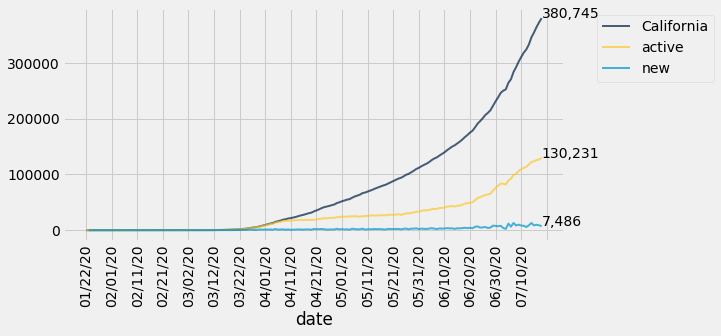

In [20]:
state_case_trend = state_cases.trend()
state_case_trend.extract([state, 'active', 'new']).oplot(width=8, xlab=20)
label_val(state_case_trend, last_day, state)
label_val(state_case_trend, last_day, 'active')
label_val(state_case_trend, last_day, 'new')


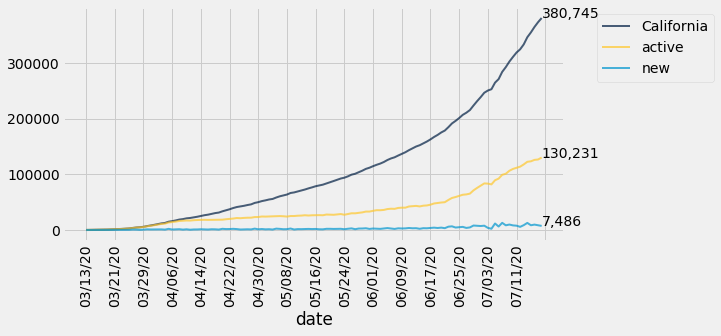

In [21]:
recent = state_case_trend.extract([state, 'active', 'new']).after("03/13/20")
recent.oplot(width=8, xlab=20)
label_val(recent, last_day, state)
label_val(recent, last_day, 'active')
label_val(recent, last_day, 'new')

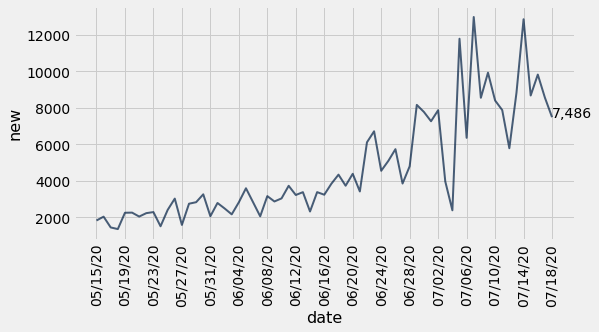

In [22]:
recent = state_case_trend.extract(['new']).after("05/15/20")
recent.oplot(width=8, xlab=20)
label_val(recent, last_day, 'new')

## Growth Rates

A much deeper picture is revealed by looking at the day-over-day growth rates across the overall course of the infection.

The daily growth rate had shot up to as muchj as 50% new cases per day for two weeks before the states finally took action.

Since that time it has been dropping steadily as the measures became broader and more consistent.  While still way to fast for the health care systems to manage, it the difference is immense.  At 17% dailey, the number of cases grows by an order of magnitude over two weeks, instead of one,

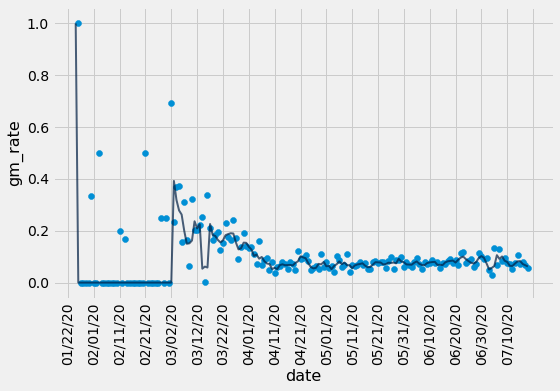

In [23]:
plot_rate_trend(state_case_trend, 'arate')

Looking at the period since mitigation measures, we find a steadily enough trend that we can hope to model the future enough to attempt predictions.

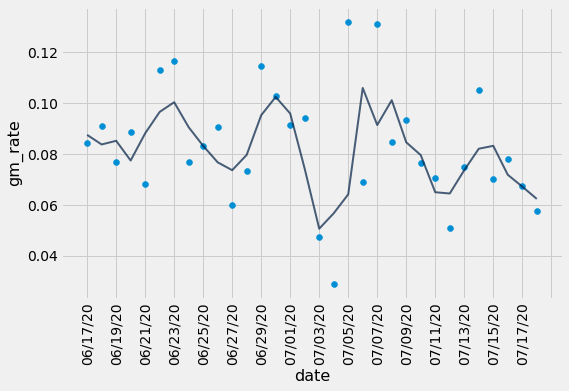

In [24]:
plot_rate_trend(state_case_trend.tail(31), 'arate')

Taking just the past two weeks, we can get a good fit.  What we are observing here is not the properties of viral infections processes, such as SIR models as more and more of the population gains immunities, it is fundamentally the reduction in transmission rates due to human behavior.  We are still at such minute level of immunity in the population that the classic epidemiological factors hardly matter.  

The challenge is what properties should we imbue to such human behavior?  Can we expect linear improvements or is the improvement a continued reduction in the oustanding rate, i.e., exponential.  Over the short term, these cannot be meaningfully differentiated.  Clearly the linear model goes negative whereas the exponential model gradually converges to zero.  

Law of small numbers and vagaries in rerporting make the daily reports pretty noisy.  But for larger states farther into the epidemic, the trends appears clear.  
The trends are so slow that we need to go out a month or to see a notable difference.

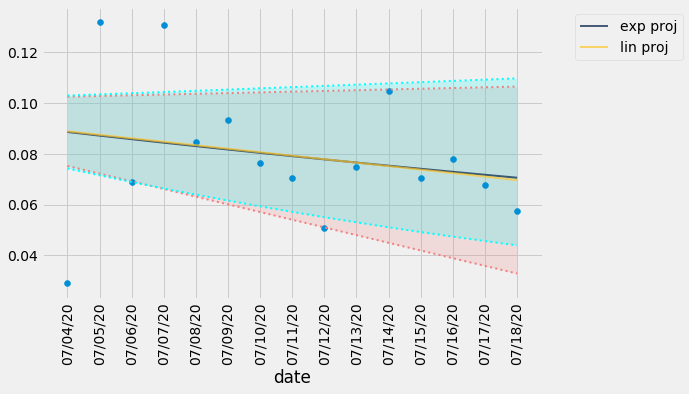

In [25]:
show_model_rate_trend(state_case_trend.tail(14))

In [26]:
state_rate_proj, eparams, lparams, ecov, lcov = model_rate_trend(state_case_trend.tail(14))

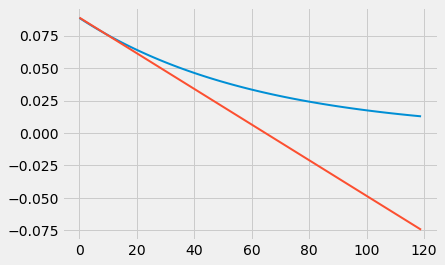

In [27]:
def ahead(n):
    plots.plot(exp_rate(range(n), eparams[0], eparams[1]))
    plots.plot(lin_rate(range(n), lparams[0], lparams[1]))

ahead(120)

## State Projections

Given some predictability, we can project grow rates into the future.  First we look projecting based on the current daily growth rate, modeling what things look like if we do just what we are seeing today, versus how they looked based on what we were seeing some days previously.

Then, given the steady reduction in rates, we project based on projecting the rate improving exponentially.

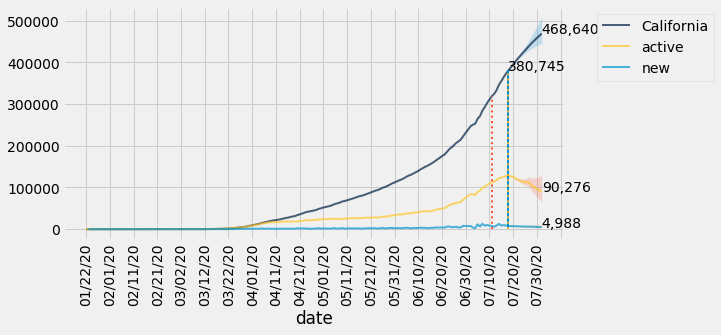

In [28]:
proj_trend(state_case_trend, state, start=7, end=0, dist=14)

In [29]:
def proj_recent(start=7, end=0, dist=21):
    proj_trend(state_case_trend.after("03/25/20"), state, start=start, end=end, dist=dist)

In [30]:
_ = interact(proj_recent, start=(7, 21, 1), end=(0, 14, 1), dist=(7, 45, 1))

interactive(children=(IntSlider(value=7, description='start', max=21, min=7), IntSlider(value=0, description='…

<a id=sectionCases></a>
## Cases to date by County

The following shows the state picture built up county by county.  Only the largest are shown, with the remainder
grouped into 'other'.

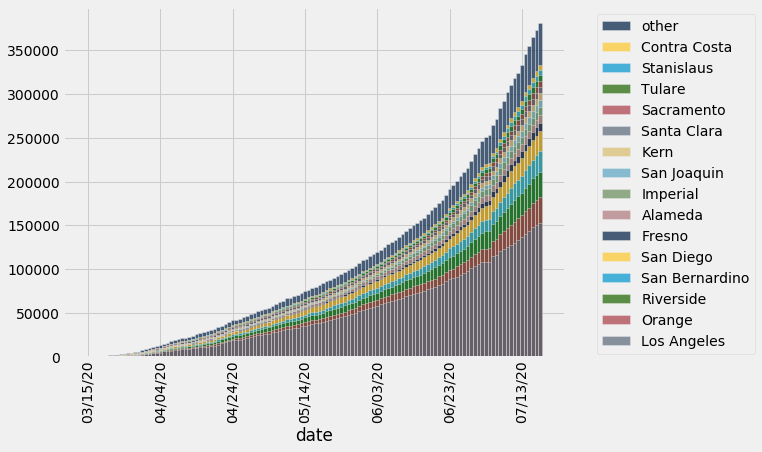

In [31]:
cases.after("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

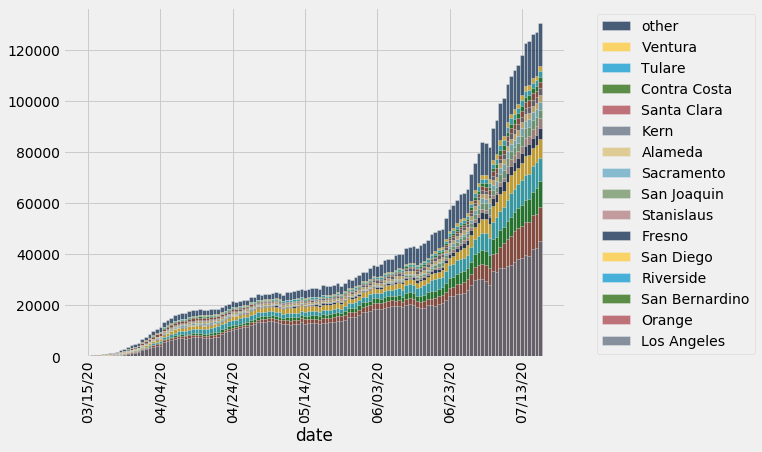

In [32]:
active.after("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

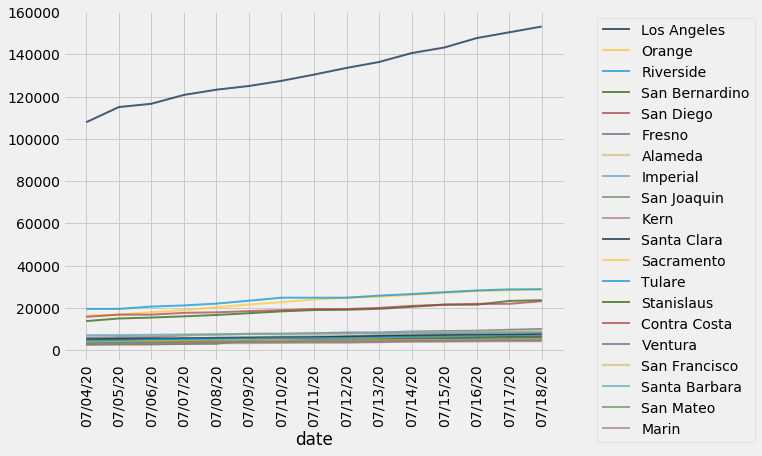

In [33]:
# Cases by county over the past two weeks
cases.top(20).tail(14).oplot(width=8, height=6)

In [34]:
def cases_since(ts, region, threshold=100):
    ctbl = ts.extract(region)
    since = ctbl.where(ctbl[region] >= threshold)
    ndays = since.num_rows
    vals = since[region]
    return vals
        
def show_cases_since(ts, threshold=100, limit=None, width=8, height=6):
        _, axis = plots.subplots(figsize=(width, height))
        for region in ts.categories :
            vals = cases_since(ts, region, threshold)
            if limit :
                vals = vals[:limit]
            axis.plot(vals)
            axis.text(len(vals), vals[-1], region)

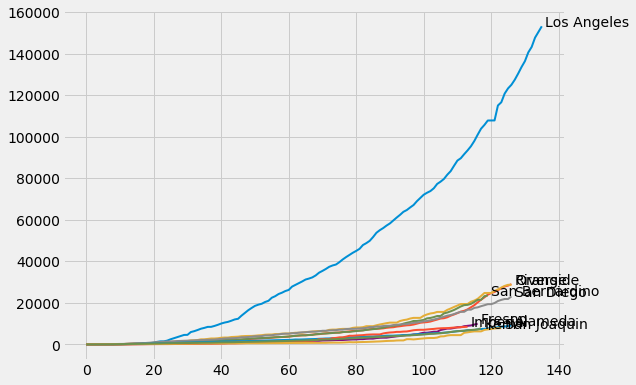

In [35]:
show_cases_since(cases.top(10), 10)

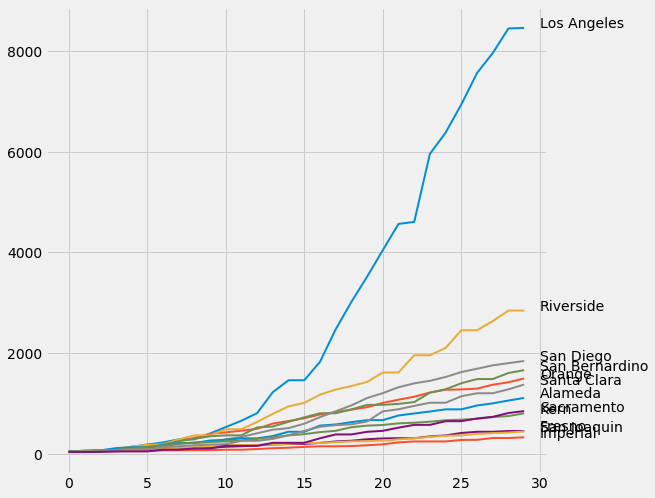

In [36]:
show_cases_since(cases.top(12), 40, 30, height=8)

In [37]:
def norm_by_population(ts):
    """Normalize region counts by population in percent"""
    normed = ts.select(ts.time_column)
    for region in ts.categories :
        if population(region) :
            normed[region] = 100*ts[region]/population(region)
    return normed

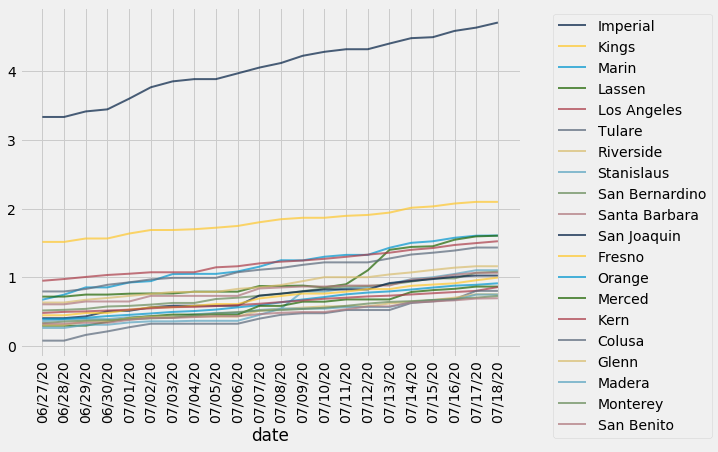

In [38]:
norm_by_population(cases).tail(21).top(20).oplot(height=6, width=8)

<a id='sectionTrends'></a>
## Growth trends by County

An important caveat is that the dirth of testing makes the number of report cases, and particularly the change in that number, messy.  Increased test coverage will tend to increase the number of confirmed cases, whereas containment and mitigation measures may actually be reducing the spread.

The `% new` columns simply look at what fraction of a day's cases are newly reported in that day.  The `rate` columns take the geometric mean of ratio of successive days over a window of the past few days. This provides a little smoothing, but it does not try to project changes in rate.  That is reflected in the series of rates.  Modulo the testing factors, this provides some indication of where measures are working or not.

Death rates are relatively insensitive to the testing error, but are such a lagging indicator they have a limited role in setting expectations for case loads.

In [39]:
cases.order_cols().trend().tail(7)

date,Los Angeles,new Los Angeles,%new Los Angeles,rate Los Angeles,active Los Angeles,arate Los Angeles,Orange,new Orange,%new Orange,rate Orange,active Orange,arate Orange,Riverside,new Riverside,%new Riverside,rate Riverside,active Riverside,arate Riverside,San Bernardino,new San Bernardino,%new San Bernardino,rate San Bernardino,active San Bernardino,arate San Bernardino,San Diego,new San Diego,%new San Diego,rate San Diego,active San Diego,arate San Diego,Fresno,new Fresno,%new Fresno,rate Fresno,active Fresno,arate Fresno,Alameda,new Alameda,%new Alameda,rate Alameda,active Alameda,arate Alameda,Imperial,new Imperial,%new Imperial,rate Imperial,active Imperial,arate Imperial,San Joaquin,new San Joaquin,%new San Joaquin,rate San Joaquin,active San Joaquin,arate San Joaquin,Kern,new Kern,%new Kern,rate Kern,active Kern,arate Kern,Santa Clara,new Santa Clara,%new Santa Clara,rate Santa Clara,active Santa Clara,arate Santa Clara,Sacramento,new Sacramento,%new Sacramento,rate Sacramento,active Sacramento,arate Sacramento,Tulare,new Tulare,%new Tulare,rate Tulare,active Tulare,arate Tulare,Stanislaus,new Stanislaus,%new Stanislaus,rate Stanislaus,active Stanislaus,arate Stanislaus,Contra Costa,new Contra Costa,%new Contra Costa,rate Contra Costa,active Contra Costa,arate Contra Costa,Ventura,new Ventura,%new Ventura,rate Ventura,active Ventura,arate Ventura,San Francisco,new San Francisco,%new San Francisco,rate San Francisco,active San Francisco,arate San Francisco,Santa Barbara,new Santa Barbara,%new Santa Barbara,rate Santa Barbara,active Santa Barbara,arate Santa Barbara,San Mateo,new San Mateo,%new San Mateo,rate San Mateo,active San Mateo,arate San Mateo,Marin,new Marin,%new Marin,rate Marin,active Marin,arate Marin,Kings,new Kings,%new Kings,rate Kings,active Kings,arate Kings,Monterey,new Monterey,%new Monterey,rate Monterey,active Monterey,arate Monterey,Solano,new Solano,%new Solano,rate Solano,active Solano,arate Solano,Merced,new Merced,%new Merced,rate Merced,active Merced,arate Merced,Sonoma,new Sonoma,%new Sonoma,rate Sonoma,active Sonoma,arate Sonoma,Placer,new Placer,%new Placer,rate Placer,active Placer,arate Placer,San Luis Obispo,new San Luis Obispo,%new San Luis Obispo,rate San Luis Obispo,active San Luis Obispo,arate San Luis Obispo,Madera,new Madera,%new Madera,rate Madera,active Madera,arate Madera,Yolo,new Yolo,%new Yolo,rate Yolo,active Yolo,arate Yolo,Santa Cruz,new Santa Cruz,%new Santa Cruz,rate Santa Cruz,active Santa Cruz,arate Santa Cruz,Napa,new Napa,%new Napa,rate Napa,active Napa,arate Napa,Butte,new Butte,%new Butte,rate Butte,active Butte,arate Butte,Lassen,new Lassen,%new Lassen,rate Lassen,active Lassen,arate Lassen,Sutter,new Sutter,%new Sutter,rate Sutter,active Sutter,arate Sutter,San Benito,new San Benito,%new San Benito,rate San Benito,active San Benito,arate San Benito,El Dorado,new El Dorado,%new El Dorado,rate El Dorado,active El Dorado,arate El Dorado,Yuba,new Yuba,%new Yuba,rate Yuba,active Yuba,arate Yuba,Shasta,new Shasta,%new Shasta,rate Shasta,active Shasta,arate Shasta,Glenn,new Glenn,%new Glenn,rate Glenn,active Glenn,arate Glenn,Nevada,new Nevada,%new Nevada,rate Nevada,active Nevada,arate Nevada,Mendocino,new Mendocino,%new Mendocino,rate Mendocino,active Mendocino,arate Mendocino,Humboldt,new Humboldt,%new Humboldt,rate Humboldt,active Humboldt,arate Humboldt,Colusa,new Colusa,%new Colusa,rate Colusa,active Colusa,arate Colusa,Lake,new Lake,%new Lake,rate Lake,active Lake,arate Lake,Tehama,new Tehama,%new Tehama,rate Tehama,active Tehama,arate Tehama,Calaveras,new Calaveras,%new Calaveras,rate Calaveras,active Calaveras,arate Calaveras,Tuolumne,new Tuolumne,%new Tuolumne,rate Tuolumne,active Tuolumne,arate Tuolumne,Mono,new Mono,%new Mono,rate Mono,active Mono,arate Mono,Del Norte,new Del Norte,%new Del Norte,rate Del Norte,active Del Norte,arate Del Norte,Amador,new Amador,%new Amador,rate Amador,active Amador,arate Amador,Siskiyou,new Siskiyou,%new Siskiyou,rate Siskiy

<a id=sectionDeaths></a>
## Deaths to date by county

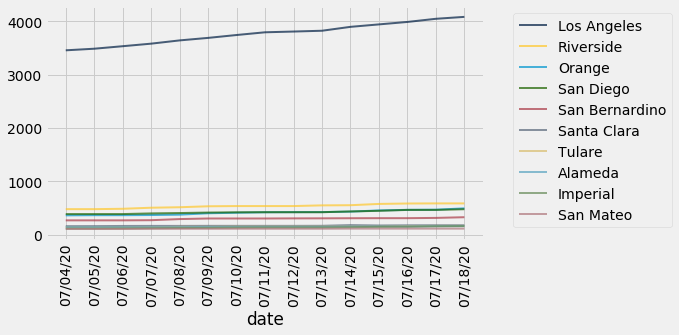

In [40]:
deaths.top(10).tail(14).oplot(width=7)

In [41]:
deaths.order_cols().trend().tail(7)

date,Los Angeles,new Los Angeles,%new Los Angeles,rate Los Angeles,active Los Angeles,arate Los Angeles,Riverside,new Riverside,%new Riverside,rate Riverside,active Riverside,arate Riverside,Orange,new Orange,%new Orange,rate Orange,active Orange,arate Orange,San Diego,new San Diego,%new San Diego,rate San Diego,active San Diego,arate San Diego,San Bernardino,new San Bernardino,%new San Bernardino,rate San Bernardino,active San Bernardino,arate San Bernardino,Santa Clara,new Santa Clara,%new Santa Clara,rate Santa Clara,active Santa Clara,arate Santa Clara,Tulare,new Tulare,%new Tulare,rate Tulare,active Tulare,arate Tulare,Alameda,new Alameda,%new Alameda,rate Alameda,active Alameda,arate Alameda,Imperial,new Imperial,%new Imperial,rate Imperial,active Imperial,arate Imperial,San Mateo,new San Mateo,%new San Mateo,rate San Mateo,active San Mateo,arate San Mateo,Kern,new Kern,%new Kern,rate Kern,active Kern,arate Kern,Fresno,new Fresno,%new Fresno,rate Fresno,active Fresno,arate Fresno,Contra Costa,new Contra Costa,%new Contra Costa,rate Contra Costa,active Contra Costa,arate Contra Costa,Sacramento,new Sacramento,%new Sacramento,rate Sacramento,active Sacramento,arate Sacramento,San Joaquin,new San Joaquin,%new San Joaquin,rate San Joaquin,active San Joaquin,arate San Joaquin,Stanislaus,new Stanislaus,%new Stanislaus,rate Stanislaus,active Stanislaus,arate Stanislaus,Ventura,new Ventura,%new Ventura,rate Ventura,active Ventura,arate Ventura,San Francisco,new San Francisco,%new San Francisco,rate San Francisco,active San Francisco,arate San Francisco,Marin,new Marin,%new Marin,rate Marin,active Marin,arate Marin,Kings,new Kings,%new Kings,rate Kings,active Kings,arate Kings,Santa Barbara,new Santa Barbara,%new Santa Barbara,rate Santa Barbara,active Santa Barbara,arate Santa Barbara,Solano,new Solano,%new Solano,rate Solano,active Solano,arate Solano,Yolo,new Yolo,%new Yolo,rate Yolo,active Yolo,arate Yolo,Sonoma,new Sonoma,%new Sonoma,rate Sonoma,active Sonoma,arate Sonoma,Monterey,new Monterey,%new Monterey,rate Monterey,active Monterey,arate Monterey,Merced,new Merced,%new Merced,rate Merced,active Merced,arate Merced,Madera,new Madera,%new Madera,rate Madera,active Madera,arate Madera,Placer,new Placer,%new Placer,rate Placer,active Placer,arate Placer,Shasta,new Shasta,%new Shasta,rate Shasta,active Shasta,arate Shasta,San Luis Obispo,new San Luis Obispo,%new San Luis Obispo,rate San Luis Obispo,active San Luis Obispo,arate San Luis Obispo,Napa,new Napa,%new Napa,rate Napa,active Napa,arate Napa,Butte,new Butte,%new Butte,rate Butte,active Butte,arate Butte,Humboldt,new Humboldt,%new Humboldt,rate Humboldt,active Humboldt,arate Humboldt,Sutter,new Sutter,%new Sutter,rate Sutter,active Sutter,arate Sutter,Santa Cruz,new Santa Cruz,%new Santa Cruz,rate Santa Cruz,active Santa Cruz,arate Santa Cruz,Yuba,new Yuba,%new Yuba,rate Yuba,active Yuba,arate Yuba,Mendocino,new Mendocino,%new Mendocino,rate Mendocino,active Mendocino,arate Mendocino,San Benito,new San Benito,%new San Benito,rate San Benito,active San Benito,arate San Benito,Glenn,new Glenn,%new Glenn,rate Glenn,active Glenn,arate Glenn,Inyo,new Inyo,%new Inyo,rate Inyo,active Inyo,arate Inyo,Lake,new Lake,%new Lake,rate Lake,active Lake,arate Lake,Mariposa,new Mariposa,%new Mariposa,rate Mariposa,active Mariposa,arate Mariposa,Mono,new Mono,%new Mono,rate Mono,active Mono,arate Mono,Nevada,new Nevada,%new Nevada,rate Nevada,active Nevada,arate Nevada,Tehama,new Tehama,%new Tehama,rate Tehama,active Tehama,arate Tehama,Alpine,new Alpine,%new Alpine,rate Alpine,active Alpine,arate Alpine,Amador,new Amador,%new Amador,rate Amador,active Amador,arate Amador,Calaveras,new Calaveras,%new Calaveras,rate Calaveras,active Calaveras,arate Calaveras,Colusa,new Colusa,%new Colusa,rate Colusa,active Colusa,arate Colusa,Del Norte,new Del Norte,%new Del Norte,rate Del Norte,active Del Norte,arate Del Norte,El Dorado,new El Dorado,%new El Dorado,rate El Dorado,active El Dorado,arate 

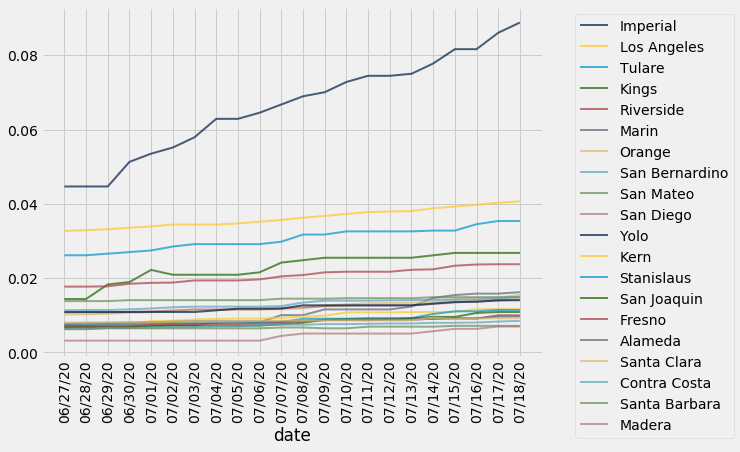

In [42]:
norm_by_population(deaths).tail(21).top(20).oplot(height=6, width=8)

## Changes in case rates

Here we try to get a handle on the spread of rates and whether they are improving.

In [43]:
get_rates(cases).tail(7)

date,Alameda,Alpine,Amador,Butte,Calaveras,Colusa,Contra Costa,Del Norte,El Dorado,Fresno,Glenn,Humboldt,Imperial,Inyo,Kern,Kings,Lake,Lassen,Los Angeles,Madera,Marin,Mariposa,Mendocino,Merced,Modoc,Mono,Monterey,Napa,Nevada,Orange,Placer,Plumas,Riverside,Sacramento,San Benito,San Bernardino,San Diego,San Francisco,San Joaquin,San Luis Obispo,San Mateo,Santa Barbara,Santa Clara,Santa Cruz,Shasta,Sierra,Siskiyou,Solano,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba,Out of CA,Unassigned
07/11/20,0.107527,nan,0.2,0,0,0.104167,0.0751685,0,0,0.0789921,0,0,0.034188,0,0.0706229,0.0716667,0,0.135922,0.0798584,0.0753138,0.0389321,0,0.162162,0.0858491,nan,0.1,0.108911,0,0,0.104765,0.0735931,0,0,0.0699588,0.181159,0.0835739,0.0728838,0.107212,0,0,0.114444,0.0529857,0.06003,0.138393,0.122222,nan,0,0,0.138199,0.0998886,0.155556,0.142857,nan,0,0,0.0801047,0,0.138211,nan,nan
07/12/20,0.00268097,nan,0,0,0,0,0.0283832,0,0,0.0987395,0,0,0,0.125,0.0753932,0.0333333,0,0.529915,0.0826695,0,0,0,0,0,nan,0.0909091,0.114701,0,0,0.0664327,0.0472103,0,0,0.053135,0.165605,0.0168967,0,0.0910816,0,0,0,0,0.136128,0.00454545,0.0851064,nan,0,0,0.0760402,0.0362372,0.0677966,0.0666667,nan,0,0.176471,0,0.105634,0.0916031,nan,nan
07/13/20,0.106245,nan,0,0,0,0,0.0931707,0.0909091,0,0,0.134831,0,0.0774793,0,0.0466321,0.0797546,0.185714,0.4375,0.0730508,0,0.151755,0.111111,0.339286,0,nan,0.0833333,0.0869565,0.165323,0,0.0426979,0.0759754,0.166667,0.0972786,0.0765827,0,0.0573678,0.0846096,0.0630798,0.182028,0.202811,0.0997921,0,0.102521,0,0.0526316,nan,0,0,0.15956,0.0843247,0.0617284,0,nan,0.118015,0,0,0.1,0.0451128,nan,nan
07/14/20,0.134818,nan,0.217391,0.314516,0.186047,0.22,0.0833333,0,0.25,0.120152,0.0875,0.0588235,0.073499,0.333333,0.0714609,0.157895,0.0151515,0.0613208,0.106492,0.213592,0.110846,0.222222,0.2,0.220015,nan,0,0.0365854,0.0545455,0.285714,0.0662531,0.0728346,0.0833333,0.0744389,0.0763463,0.194595,0.110174,0.13579,0.0463392,0.0580892,0.1409,0.119766,0.274702,0.0743902,0.123506,0.032967,nan,0.133333,0.200505,0.0872396,0.120025,0.143396,0.304348,nan,0.114249,0.0625,0.19851,0.1417,0.153333,nan,nan
07/15/20,0.0624503,nan,0.115385,0.0780669,0,0.0531915,0.0582669,0,0.0702703,0.0447942,0.0804598,0.190476,0.0136626,0,0.0714916,0.0420168,0.150685,0.0139535,0.0668496,0.090106,0.0339666,0,0.116883,0.0601093,nan,0.166667,0.061369,0.127049,0.0277778,0.0690779,0.0331263,0.0833333,0.0883375,0.0799729,0.0512821,0.113478,0.0766068,0.0512351,0.0593505,0.0678643,0.0841487,0.0587071,0.087563,0.00896861,0.116505,nan,0,0.0733802,0.068323,0.048031,0,0.0980392,nan,0.0565257,0.0769231,0.090274,0.046332,0,nan,nan
07/16/20,0.0602995,nan,0.04,0.167785,0,0.0795455,0.0468514,0.0909091,0.0983607,0.0477184,0.117647,0.0666667,0.0923335,0.166667,0.0663487,0.0958084,0.0689655,0.120833,0.106419,0,0.077791,0.125,0.125,0.0448393,nan,0.428571,0.0541796,0.0693878,0.15,0.0647098,0.0751566,0.0833333,0.0795185,0.0737158,0.0558659,0,0.0565542,0.135314,0.0669145,0.0891473,0.0772994,0.128235,0.0383994,0.338762,0.0549451,nan,0.0769231,0.0703053,0.0478589,0.0749928,0.109489,0,nan,0.0686138,0.0740741,0.096688,0.0769231,0.105634,nan,nan
07/17/20,0.0933711,nan,0.08,0.110759,0.352941,0.252427,0.0706628,0,0.0691489,0.111957,0.152174,0.0697674,0.0553083,-0.2,0.0693112,0.0591054,0.0545455,0.0590551,0.0644117,0.203915,0.0461718,0,0.130435,0.0753138,nan,0.0833333,0.057971,0.0209205,0.0864198,0.0305799,0.0665281,0.0833333,0.0519298,0.0392954,0.0903955,0.175491,0,0.0915605,0.0394774,0.10223,0.0681597,0.082777,0.0356993,0.0920245,0.076087,nan,0,0.0658627,0.0601504,0.081389,0.0701754,0.173913,nan,0.0938945,0.0238095,0,0.0752896,0.107383,nan,nan
07/18/20,0.0955269,nan,0,0,0,0,0.0759734,0.266667,0,0.0898799,0,0,0.0863402,0,0.188356,0,0,0.0116732,0.0601597,0,0.00481431,0,0.08,0,nan,0.314286,0.0751276,0,0,0.0530492,0.0910931,0,0,0.0580728,0.0166667,0.0331648,0.169722,0.105224,0,0,0.0605469,0,0.0689514,0.101408,0,nan,0,0,0.051186,0,0,0,nan,0,0,0.114754,0,0,nan,nan


In [44]:
def get_new(trend, region):
    return trend.last('new ' + region)

def get_rate(trend, region):
    return trend.last('rate ' + region)

def get_active(trend, region):
    return trend.last('active ' + region)

def get_arate(trend, region):
    return trend.last('arate ' + region)

def get_val(trend, region):
    return trend.last(region)

def summary(ts, name, regions):
    trend = ts.trend()
    smry = Table().with_columns(
        name, regions,
        'confirmed', [get_val(trend, r) for r in regions],
        'new',       [get_new(trend, r) for r in regions],
        'rate',      [get_rate(trend, r) for r in regions],
        'active',    [get_active(trend, r) for r in regions],
        'arate',     [get_arate(trend, r) for r in regions]

    )
    params = [fit(lin_rate, ts.extract(r).trend().tail(7)) for r in regions]
    smry['eff arate'] = [p[0][0] for p in params]
    smry['delta']    = [p[0][1] for p in params]
    smry['err']      = [p[1][1] for p in params]
    return smry.where(np.isfinite(smry['err']))

def label_point(summary, region, x, y):
    t = summary.where(name, region)
    if np.isfinite(t[x][0]) and np.isfinite(t[y][0]) :
        plots.text(t[x][0], t[y][0], region)

In [45]:
case_sum = summary(cases, 'county', counties)
case_sum.sort('delta', descending=True)

county,confirmed,new,rate,active,arate,eff arate,delta,err
Mono,76,11,1.16923,35,0.314286,0.0473665,0.0317203,0.0198634
Del Norte,66,4,1.06452,15,0.266667,-0.0217172,0.0222222,0.0128725
Calaveras,87,0,1,34,0,0.00159599,0.0187936,0.0207051
Santa Cruz,772,36,1.04891,355,0.101408,0.0559404,0.0128602,0.0177666
Kern,7728,495,1.06844,2628,0.188356,0.0469144,0.0101536,0.00598656
Butte,522,0,1,316,0,0.049695,0.00977029,0.0183791
Glenn,214,0,1,92,0,0.042315,0.00836043,0.0100368
Humboldt,181,0,1,37,0,0.019863,0.00810107,0.010484
Imperial,8531,134,1.01596,1552,0.0863402,0.0280042,0.00745635,0.00489939
Nevada,204,0,1,81,0,0.0427322,0.0074305,0.0169328


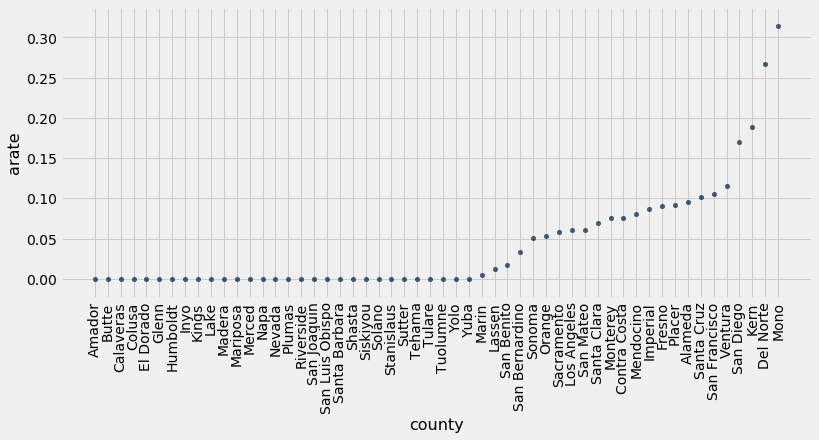

In [46]:
case_sum.select('county', 'arate').sort('arate').scatter('county', width=12)
_ = plots.xticks(rotation=90)

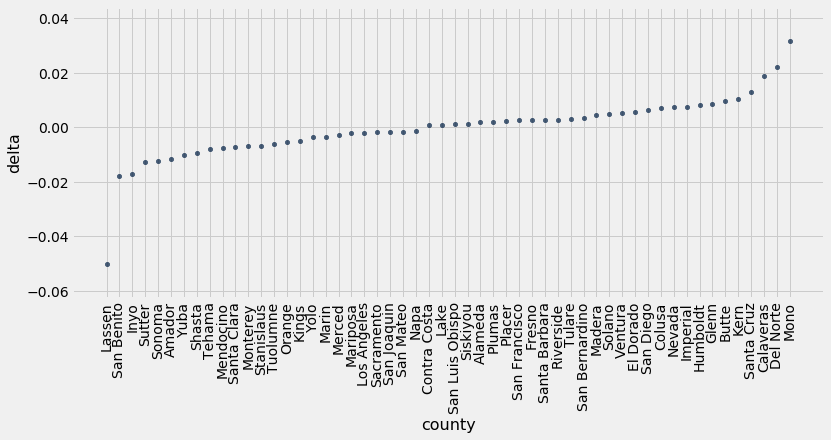

In [47]:
case_sum.select('county', 'delta').sort('delta').scatter('county', width=12)
_ = plots.xticks(rotation=90)

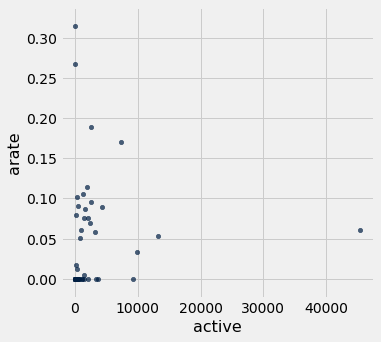

In [48]:
case_sum.scatter('active', 'arate')

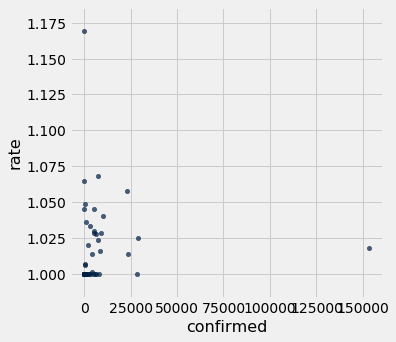

In [49]:
case_sum.scatter('confirmed', 'rate')

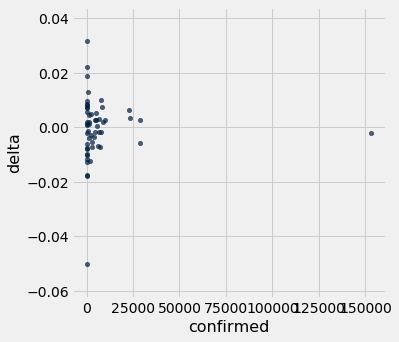

In [50]:
case_sum.scatter('confirmed', 'delta')

<a id='sectionOneState'></a>
## Cases in one County

These sections of the notebook allow diving into the picture for a particular county.  We start with the basic trends and then look at projects up to a couple weeks out.  Things are changing so rapidly, it is pretty meaningless to talk about numbers farther out than that.  Whereas just looking at the short term puts in stark relief how rapidly we need to move in preparing to care for infected people.

In [51]:
w = widgets.Dropdown(options=list(counties), description='County')
display(w)

Dropdown(description='County', options=('Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra…

In [52]:
from IPython.core.display import HTML
HTML('''<script> </script> <form action="javascript:IPython.notebook.execute_cells_below()"><input type="submit" id="toggleButton" value="Run All Below"></form>''')

In [53]:
region = w.value
region_case_trend = cases.extract(region).trend()
region

'Alameda'

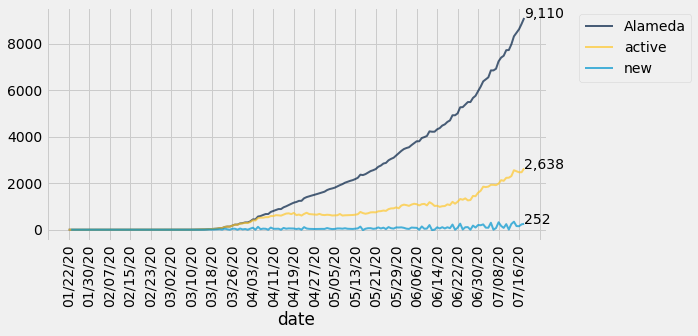

In [54]:
region_case_trend.extract([region, 'active', 'new']).oplot(width=8, xlab=25)
label_val(region_case_trend, last_day, region)
label_val(region_case_trend, last_day, 'active')
label_val(region_case_trend, last_day, 'new')

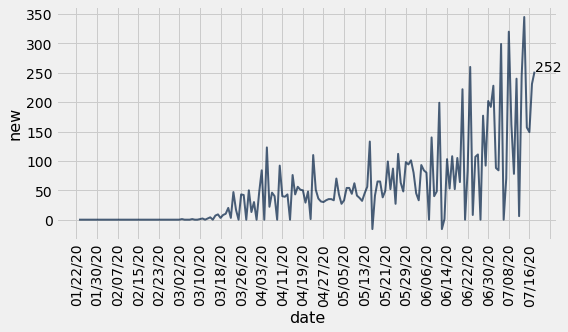

In [55]:
region_case_trend.extract(['new']).oplot(width=8, xlab=25)
label_val(region_case_trend, last_day, 'new')

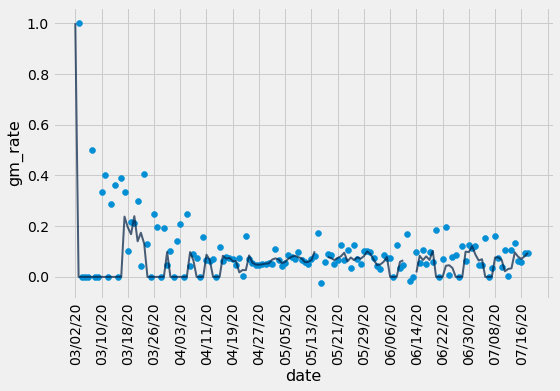

In [56]:
plot_rate_trend(region_case_trend, 'arate')

In [57]:
region_recent = region_case_trend.after("04/01/20")

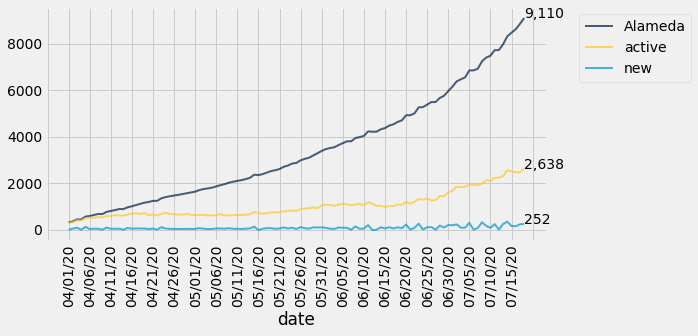

In [58]:
region_recent.extract([region, 'active', 'new']).oplot(width=8, xlab=25)
label_val(region_recent, last_day, region)
label_val(region_recent, last_day, 'active')
label_val(region_recent, last_day, 'new')

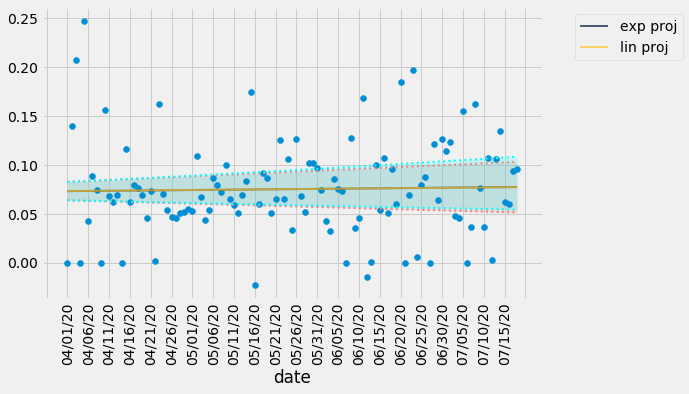

In [59]:
show_model_rate_trend(region_recent, 'arate')

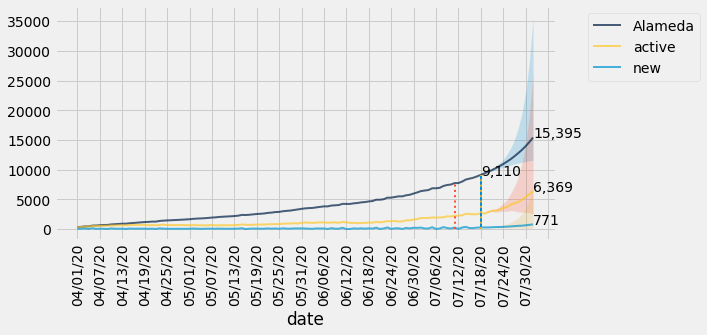

In [60]:
proj_trend(region_recent, region, start=7, end=0, dist=14)

In [61]:
def proj_recent(start=7, end=0, dist=21):
    proj_trend(region_recent, region, start=start, end=end, dist=dist)

In [62]:
_ = interact(proj_recent, start=(5, 21, 1), end=(0, 14, 1), dist=(7, 30, 1))

interactive(children=(IntSlider(value=7, description='start', max=21, min=5), IntSlider(value=0, description='…